# Fake News Classifier using LSTM

## Introduction

Fake News has been a concern all over the world and social media has only amplified this phenomenon. Fake News has been affecting the world on a large scale as these are targeted to sway the decisions of the crowd in a particular direction. Since manually verifying the legitimacy of news is very hard and costly, there has been a great interest of researchers in this field. Different approaches to identifying fake news were examined, such as content-based classification, social context-based classification, image-based classification, sentiment-based classification, and hybrid context-based classification.





###Loading Data From Kaggle


Dataset: https://www.kaggle.com/c/fake-news/data#

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle competitions download -c fake-news

 71% 33.0M/46.5M [00:01<00:00, 30.4MB/s]
100% 46.5M/46.5M [00:01<00:00, 35.3MB/s]


In [3]:
!unzip fake-news.zip


Archive:  fake-news.zip
  inflating: submit.csv              
  inflating: test.csv                
  inflating: train.csv               


###Importing Data 

In [4]:
import pandas as pd
data=pd.read_csv("train.csv")
data.head(10)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


###Removing NaN Values from the dataset

In [5]:
data=data.dropna()
data.reset_index(inplace=True)

###Extracting Dependent and Independent variables from data

In [6]:
X = data.drop("label",axis=1)
y = data["label"]

###Checking The Shape of X and y

In [7]:
print(X.shape)
print(y.shape)

(18285, 5)
(18285,)


###Importing the required Libraries

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

###Preprocessing the text

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
messages=X.copy()
ps = PorterStemmer()
corpus = []
for i in range(len(messages)):
  review = re.sub("[^a-zA-Z]"," ",messages['title'][i])
  review = review.lower()
  review = review.split()
  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]  # (word not in stopwords) and stem(word)
  review = ' '.join(review)
  corpus.append(review)

###One Hot Encoding

In [11]:
vocab_size=5000
onehot_repr=[one_hot(words,vocab_size)for words in corpus] 
onehot_repr

[[2640, 2122, 347, 1167, 3548, 466, 4532, 3057, 3511, 2765],
 [4319, 273, 564, 4794, 259, 4171, 2718],
 [112, 837, 65, 2080],
 [3156, 2557, 2944, 2651, 2262, 1018],
 [2722, 259, 3106, 244, 516, 917, 259, 3064, 1112, 221],
 [3444,
  698,
  4644,
  3828,
  677,
  2077,
  634,
  2356,
  412,
  609,
  2458,
  2727,
  426,
  2815,
  2718],
 [617, 1184, 4010, 4575, 1373, 3389, 3203, 62, 3308, 3676, 3251],
 [3877, 3041, 578, 4147, 2281, 4347, 2077, 145, 3308, 3676, 3251],
 [1408, 3971, 963, 3275, 4670, 399, 1436, 4213, 2077, 4397],
 [1200, 2651, 2697, 4825, 4650, 4872, 3647, 700],
 [4882, 3740, 732, 4966, 4413, 3468, 3623, 1530, 525, 4723, 1361],
 [2651, 3815, 3548, 399, 2077, 2281],
 [1802, 1150, 937, 810, 4460, 3639, 2273, 1983, 2257],
 [734, 3139, 3063, 149, 2369, 1362, 3060, 3308, 3676, 3251],
 [113, 1561, 2331, 3684, 2454, 3308, 3676, 3251],
 [1590, 2378, 298, 2266, 2110, 4917, 3524, 2377, 1610, 2067],
 [4499, 3253, 273],
 [2269, 3560, 2649, 593, 2077, 208, 1098, 2718],
 [624, 1434, 564,

###Applying Pad Sequences To Make Sentence Length Equal

In [12]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 3057 3511 2765]
 [   0    0    0 ...  259 4171 2718]
 [   0    0    0 ...  837   65 2080]
 ...
 [   0    0    0 ... 3308 3676 3251]
 [   0    0    0 ...  167 1133 2302]
 [   0    0    0 ... 4101   85 3831]]


#Creating Model for Train Set

In [41]:
embedding_vector_features=50
model=Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(148))
model.add(Dense(128, activation="sigmoid"))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 50)            250000    
                                                                 
 lstm_4 (LSTM)               (None, 148)               117808    
                                                                 
 dense_10 (Dense)            (None, 128)               19072     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 387,009
Trainable params: 387,009
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=26)

In [45]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)
#model.save("model.pkl")

Epoch 1/10
229/229 [==============================] - 2s 7ms/step - loss: 0.0832 - accuracy: 0.9740 - val_loss: 0.0669 - val_accuracy: 0.9784
Epoch 2/10
229/229 [==============================] - 2s 7ms/step - loss: 0.0264 - accuracy: 0.9918 - val_loss: 0.0831 - val_accuracy: 0.9740
Epoch 3/10
229/229 [==============================] - 2s 7ms/step - loss: 0.0086 - accuracy: 0.9977 - val_loss: 0.1063 - val_accuracy: 0.9705
Epoch 4/10
229/229 [==============================] - 1s 6ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.1233 - val_accuracy: 0.9691
Epoch 5/10
229/229 [==============================] - 2s 8ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.1299 - val_accuracy: 0.9696
Epoch 6/10
229/229 [==============================] - 2s 7ms/step - loss: 2.1744e-04 - accuracy: 1.0000 - val_loss: 0.1465 - val_accuracy: 0.9710
Epoch 7/10
229/229 [==============================] - 2s 7ms/step - loss: 1.1078e-04 - accuracy: 1.0000 - val_loss: 0.1548 - val_accuracy: 0.969

### Accuracy Plot

<Figure size 432x288 with 0 Axes>

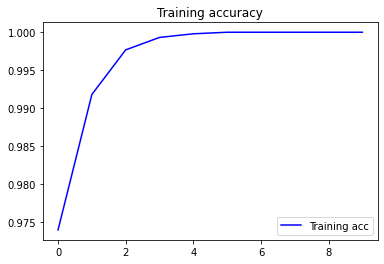

<Figure size 432x288 with 0 Axes>

In [46]:
import matplotlib.pyplot as plt



acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')

plt.title('Training accuracy')
plt.legend()
 
plt.figure()

### Loss Plot

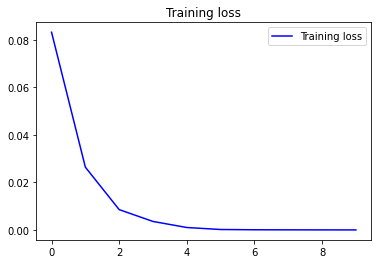

In [47]:
plt.plot(epochs, loss, 'b', label='Training loss')

plt.title('Training loss')
plt.legend()
 
plt.show()

###Performance Metrics And Accuracy



In [48]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[2002,   60],
       [  46, 1549]])

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score


acc = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)


print("Accuracy : ",acc)
print("Precision : ",precision)
print("Recall : ",recall)
print("Confusion Matrix : \n",confusion_matrix(y_test,y_pred))

Accuracy :  0.9710144927536232
Precision :  0.9627097576134245
Recall :  0.9711598746081505
Confusion Matrix : 
 [[2002   60]
 [  46 1549]]


In [50]:
model.save('model.pkl')